In [1]:
% matplotlib inline

from __future__ import division
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend
from scipy.spatial.distance import pdist, squareform
import scipy.signal as signal
import time as tm
import gsw as sw


from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def convert_KM(sds):
    lon_tmp = sds[(sds['cruise']=='KiloMoana_1')]['lon']
    lon_tmp = lon_tmp//100 + (lon_tmp - lon_tmp//100*100)/60
    lat_tmp = sds[(sds['cruise']=='KiloMoana_1')]['lat']
    lat_tmp = lat_tmp//100 + (lat_tmp - lat_tmp//100*100)/60
    
    sds.loc[sds['cruise']=='KiloMoana_1','lon'] = -lon_tmp
    sds.loc[sds['cruise']=='KiloMoana_1','lat'] = lat_tmp
    
    lon_tmp2 = sds[(sds['cruise']=='SCOPE_2')]['lon']
    lon_tmp2 = lon_tmp2//100 + (lon_tmp2 - lon_tmp2//100*100)/60
    lat_tmp2 = sds[(sds['cruise']=='SCOPE_2')]['lat']
    lat_tmp2 = lat_tmp2//100 + (lat_tmp2 - lat_tmp2//100*100)/60
    
    sds.loc[sds['cruise']=='SCOPE_2','lon'] = -lon_tmp2
    sds.loc[sds['cruise']=='SCOPE_2','lat'] = lat_tmp2
    
    return sds

def checklon(data):
    cxx = (data['lon']).values # longitude

    # convert all longitude to longitude east
    cxx[cxx<0]= 360+cxx[cxx<0];
    data['lon_e'] = cxx
    cxbew = cxx
    cxbew[cxbew>180] = cxbew[cxbew>180]-360   
    data['lon'] = cxbew
    return data

def distance(data):
    cruise = pd.unique(data['cruise'])
    distances = pd.DataFrame()    
    for c in cruise:
        temp = pd.DataFrame()
        temp = data.loc[(data['cruise']==c), ['cruise','file_time','lon','lat']]
        
        # calculate distance in km between points
        temp['dx'] = np.insert(sw.distance(temp['lon'].values, temp['lat'].values, 0),0,0)/1000
        temp['x'] = np.cumsum(temp['dx'])
        
        if c == cruise[0]:
            distances = distances.append(temp)
        else:
            distances = pd.concat([distances, temp], axis=0)
        del temp
    data = pd.merge(left = data, right = distances, how='left', left_on=['cruise','file_time','lat','lon'], right_on=['cruise','file_time','lat','lon'])
    #return distances

    return data  

def tracks(data):
    seg = []
    start = 0
    n = 1
    for i in range(len(data)):
        if ((data['dx'][i] > 20) | (data['dx'][i] < 0.01)):
            seg.append([data['cruise'][i], start, i-1, sum(data['dx'][start:i-1])])# - data['x'][start])])
                                                         
            n += 1
            start = i+1
    
    segments = pd.DataFrame(seg, columns = ['cruise', 'start', 'end', 'length']) 
    segments = segments.loc[(segments['length'] >= 200)]
    segments = segments.loc[(segments['end'] > 0)]
    segments['number'] = range(1, len(segments)+1)
    segments = segments.set_index(['number'])
    return segments

def getscales(data, segments, var, var2, offset):
    scales = pd.DataFrame()
    seg_fft = pd.DataFrame()
    
    for i in range(1, len(segments)+1):
        a = segments['start'][i]
        b = segments['end'][i]
        
        tmp = data[a:b]
        segnumber = i
        cruise = segments['cruise'][i]
        aa = data['x'][a]
        bb = data['x'][b]
        
       
        tmp = interpdata(tmp, aa, bb, var)
        seglength = len(tmp)
       
        tmp1 = detrenddata(tmp, var2) 
            
        # start the decorrelation calculation here
        tmp2, tmp3 = fft_data(tmp1, var2, cruise, segnumber)
            # append the scale data for each segment to the scales dataframe
        
        if i == 1 :
            scales = scales.append(tmp2)
            seg_fft = seg_fft.append(tmp3)
        else:
            scales = pd.concat([scales, tmp2], axis=0)
            seg_fft = seg_fft.merge(tmp3, left_on='wavenumber', right_on='wavenumber', how='outer')

        del tmp2, tmp1, tmp3

            
    scales['number'] = range(len(scales))
    scales = scales.set_index(['number'])    
    return scales, seg_fft
        
        
def fft_data(detdata, var, cruise, segnumber):
    # initialize the dataframe for the scales
    scales = pd.DataFrame()
    seg_fft = pd.DataFrame()
   
    # set the length of the segments to look at
    ll = len(detdata) # length of decorrelation segment
    
    
    scales['lat'] = (detdata['lat'].values)[ll/2]
    scales['lon'] = (detdata['lon'].values)[ll/2]
    scales['depth_mid'] = (detdata['depth'].values)[ll/2]
    scales['dcoast_mean'] = np.nanmean(detdata['dcoast'].values)
    scales['dcoast_mid'] = (detdata['dcoast'].values)[ll/2]
    scales['depth_mean'] = np.nanmean(detdata['depth'].values)
    scales['cruise'] = cruise
    scales['segment #'] = segnumber
    print segnumber, ll, cruise, (detdata['lat'].values)[ll/2], (detdata['lon'].values)[ll/2], np.mean(detdata['dom_group'].values)
    
    
    freq = np.fft.fftfreq(ll, 1.0)
    seg_fft['wavenumber'] = freq
        
    for v in var:

        tmp = detdata[v]

        # initialize array for the results, needs to b 3 cols, length t
        data = tmp
        yf = np.fft.fft(data*np.hanning(len(data)))
                                         
        # append to the scales dataframe
        v2 = '%s_%d' % (v, segnumber)
       
        seg_fft[v2] = yf
        del yf
            
    return scales, seg_fft
        

def interpdata(track, aa, bb, var):
    # we went to create a new dataframe which has the interpolated data for each track for all variables, 
    # and a position.
    intdata = pd.DataFrame()
    # set the interpolation distance 
    n = 1 # 1km 
    begin = np.floor(track['x'][:1])
    intdata['x'] = np.arange(aa, bb, n)
 
    for v in var:
        intdata[v] = np.interp(intdata['x'].values,track['x'].values,track[v].values)
          
    return intdata
        
def detrenddata(track, var2):
    # take the interpolated data and remove the large scale trend, e.g. apply a high pass filter.
    detdata = pd.DataFrame()
    detdata['x'] = track['x']
    detdata['lon'] = track['lon']
    detdata['lat'] = track['lat']
    detdata['depth'] = track['depth']
    detdata['dcoast'] = track['dcoast']
    detdata['dom_group'] = track['dom_group']
    

    # First, design the Butterworth filter
    N  = 3    # Filter order
    cutoff = 250. # length scale for cutoff
    Wn = 1/cutoff # Cutoff wavelength, normalised to n
    B, A = signal.butter(N, Wn, 'low', output='ba')
    
    # Second, apply the filter to each of the variables
    
    for v in var2:
        detdata[v] = track[v] - signal.filtfilt(B,A, track[v])
    return detdata
    

def fftbin(fft, bins, bin_mid):
    
    y = 1/(np.abs(fft['wavenumber'].values))
    
    binned = pd.DataFrame()
    bin_count = np.zeros(len(bins)-1)
    binned['k_mid'] = bin_mid
    
    var = fft.columns
    for v in var:
        
        z = np.abs(fft[v].values) # bead attribute

        digitized = np.digitize(y, bins)
        bin_count = [np.shape(z[digitized == i])[0] for i in range(1, len(bins))]

        bin_means = [np.nanmean(z[digitized == i]) for i in range(1, len(bins))]
        bin_std = [np.nanstd(z[digitized == i]) for i in range(1, len(bins))]
        
        binned[v] = bin_means

    return binned   

def most_abundant(row):
    if row['pico'] > row['synecho'] and row['pico'] > row['picoeuk']: 
        return 1
    if row['synecho'] > row['pico'] and row['synecho'] > row['picoeuk']: 
        return 2
    if row['picoeuk'] > row['synecho'] and row['picoeuk'] > row['pico']: 
        return 3    

In [3]:
# import mega dataset
filePath = '/Users/sclayton/Google Drive/seaflow_data/abun_sds_opp.csv'
data = pd.read_csv(filePath, sep=',')
print data.columns

filePath = r'/Users/sclayton/Google Drive/seaflow_data/sds_depth.csv'
depth = pd.read_csv(filePath)

filePath = r'/Users/sclayton/Google Drive/seaflow_data/sds_dist2coast.csv'
dcoast = pd.read_csv(filePath)


Index([u'Unnamed: 0', u'Unnamed: 0.1', u'tot_chl', u'cruise', u'file_time',
       u'Unnamed: 0.1', u'file_duration', u'lat', u'lon', u'conductivity',
       u'salinity', u'ocean_tmp', u'par', u'bulk_red', u'stream_pressure',
       u'flow_rate', u'event_rate', u'avg_chl', u'avg_pe', u'avg_fsc',
       u'density', u'lon_e', u'dx', u'x', u'sds_time', u'file_time_r',
       u'opp.evt', u'ts', u'beads', u'cocco', u'crypto', u'diatoms',
       u'file_time_r.1', u'lgdiatoms', u'pico', u'picoeuk', u'smdiatoms',
       u'synecho', u'unknown'],
      dtype='object')


In [4]:
# add density 
data['density'] = sw.rho(data['salinity'].values,data['ocean_tmp'].values,0)
data = checklon(data)
               
# sort the dataframe so that it is in date/time order
data = pd.merge(data, depth, on=['cruise','file_time'], how='inner')
data = pd.merge(data, dcoast, on=['cruise','file_time'], how='inner')
data = data.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
data = data.reset_index(drop=True)

# now we have a dataframe with the total alongtrack distance for each cruise, 
# and the distance between points for each file.

clean = data[['cruise', 'file_time', 'lon', 'lon_e', 'lat', 'depth', 'dcoast', 'salinity', 'ocean_tmp', 'density', 'pico', 'synecho', 'picoeuk']]
clean['tot_chl'] = data['tot_chl']#/(data['file_duration']*data['opp.evt']*data['flow_rate'])
clean = clean.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
clean['dom_group']= clean.apply(most_abundant, axis =1)
clean = distance(clean)


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# split the data into continuous segments at least 200 km long with no gaps bigger than 20 km.
segments = tracks(clean)

# now do the length scale analysis
# interpolate the data, detrend it using the low pass filter, then find the decorrelation scales
# loop over each segment
var = ['lat', 'lon', 'tot_chl', 'ocean_tmp', 'salinity', 'density', 'synecho', 'pico', 'picoeuk','depth', 'dcoast', 'dom_group']
var2 = ['tot_chl', 'ocean_tmp', 'salinity', 'density', 'synecho', 'pico', 'picoeuk']

scales, seg_fft = getscales(clean, segments, var, var2, 200)
#seg_fft = seg_fft.sort(['wavenumber'], ascending=True)

1 342 CMOP_3 46.3906188906 -124.853512725 2.7983239538
2 929 DeepDOM -37.3324387438 -48.7404541409 nan
3 465 DeepDOM -36.2528920017 -43.8799334078 1.0
4 395 DeepDOM -32.9048294828 -41.7581244922 1.0
5 432 DeepDOM -29.6652100553 -39.6651457697 1.0
6 426 DeepDOM -23.7794407019 -34.5186086975 1.0
7 883 DeepDOM -18.5668026658 -32.470289424 1.0
8 430 DeepDOM -15.2663376968 -28.2519891385 1.0
9 477 DeepDOM -11.4574976958 -26.7391002125 1.0
10 518 DeepDOM -7.7279209567 -25.0599213978 1.0
11 229 DeepDOM -5.70631958024 -24.9745350388 1.0
12 275 DeepDOM -5.70960422744 -27.2748494598 1.0
13 209 DeepDOM -4.7824741697 -28.5255563924 1.0
14 489 DeepDOM 0.655794855756 -35.0087566849 1.0
15 265 DeepDOM 2.66209492005 -38.158965666 1.0
16 370 DeepDOM 4.72029711901 -40.1494283021 1.0
17 429 DeepDOM 5.90069599555 -43.2292322348 1.0
18 340 DeepDOM 6.20872319861 -46.5439334921 1.0
19 301 DeepDOM 7.3770970109 -49.0079679201 1.0
20 857 DeepDOM 9.99453907073 -53.2228039085 1.00149267975
21 296 KiloMoana_1 49.1

/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:118: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:119: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:120: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:122: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:126: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
# try averaging out the spectra...
# wavenumbers for bins
k_bins = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 250, 500, 1000, 2500, 5000]
k_bin_mid = k_bins[:(len(k_bins)-1)] + np.diff(k_bins)/2

binned = fftbin(seg_fft, k_bins, k_bin_mid)

bin_mean = pd.DataFrame()
bin_mean['k_mid'] = binned['k_mid']

add = np.zeros(len(binned))
#add[:] = np.NAN

for v in var2:
    tmp = pd.DataFrame()
    for n in range(4,7, 1):
        m = '%s_%d' % (v, n)
        tmp[m] = binned[m]
    
    sd = '%s_sd' % v
    bin_mean[v] = tmp.mean(axis = 1, skipna = True)
    bin_mean[sd] = tmp.std(axis = 1, skipna = True)
    


/Users/sclayton/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/sclayton/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [7]:
print bin_mean


     k_mid       tot_chl    tot_chl_sd  ocean_tmp  ocean_tmp_sd  salinity  \
0      0.5           NaN           NaN        NaN           NaN       NaN   
1      1.5           NaN           NaN        NaN           NaN       NaN   
2      2.5  8.974238e+06  3.011782e+06   0.028167      0.004348  0.025517   
3      3.5  1.384308e+07  6.592616e+06   0.072542      0.008435  0.057325   
4      4.5  1.727837e+07  9.551668e+06   0.117089      0.005685  0.093990   
5      7.5  2.343141e+07  9.355383e+06   0.353790      0.025307  0.250597   
6     15.0  3.976347e+07  7.975612e+06   0.944500      0.223890  0.555635   
7     25.0  6.341954e+07  1.407304e+07   2.204153      0.961630  1.469987   
8     35.0  5.024793e+07  2.383487e+07   2.748016      1.226600  1.633482   
9     45.0  6.438542e+07  3.292027e+07   4.349357      2.384822  2.195726   
10    75.0  1.332260e+08  1.101835e+06   5.933107      0.381146  3.384017   
11   175.0  2.375251e+08  1.524881e+08  14.116596      7.357225  7.425793   

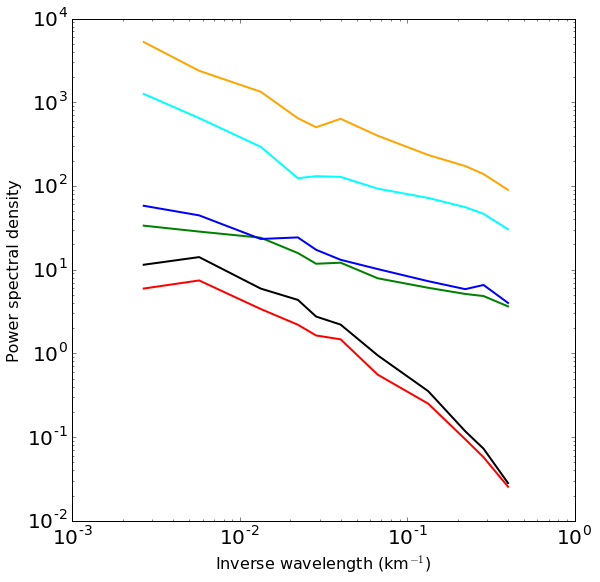

In [8]:
fig3 = plt.figure(3, figsize=(9,9), dpi = 600)

plt.loglog(1./bin_mean['k_mid'], np.abs(bin_mean['ocean_tmp']), 'k', lw=2)
plt.loglog(1./bin_mean['k_mid'], np.abs(bin_mean['salinity']), 'r', lw=2)
plt.loglog(1./bin_mean['k_mid'], np.abs(bin_mean['picoeuk']), 'g', lw=2)
plt.loglog(1./bin_mean['k_mid'], np.abs(bin_mean['synecho']), 'b', lw=2)
plt.loglog(1./bin_mean['k_mid'], np.abs(bin_mean['pico']), 'cyan', lw=2)
plt.loglog(1./bin_mean['k_mid'], np.abs(bin_mean['tot_chl']/100000), 'orange', lw=2)


plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
plt.ylabel('Power spectral density', fontsize = 16)

plt.show()

# green = picoeuk
# cyan = pro*
# blue = synecho
# red = salinity
# black = temp
# orange = chl

# plt.loglog(seg_fft['wavenumber'], 20**(-1)*(seg_fft['wavenumber']**(-2)), 'grey')
# plt.loglog(seg_fft['wavenumber'], 10**(-4)*(seg_fft['wavenumber']**(-3)), 'grey')

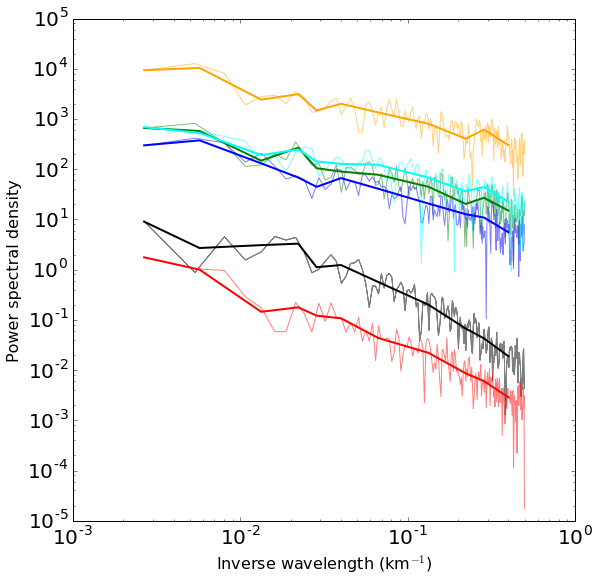

In [9]:
fig3 = plt.figure(3, figsize=(9,9), dpi = 600)

plt.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_24']), 'k', alpha=0.5)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_24']), 'r', alpha=0.5)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_24']), 'g', alpha=0.5)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_24']), 'b', alpha=0.5)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_24']), 'cyan', alpha=0.5)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_24']/100000), 'orange', alpha=0.5)

plt.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_24']), 'k', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['salinity_24']), 'r', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_24']), 'g', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['synecho_24']), 'b', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['pico_24']), 'cyan', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_24']/100000), 'orange', lw=2)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
plt.ylabel('Power spectral density', fontsize = 16)

plt.show()

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

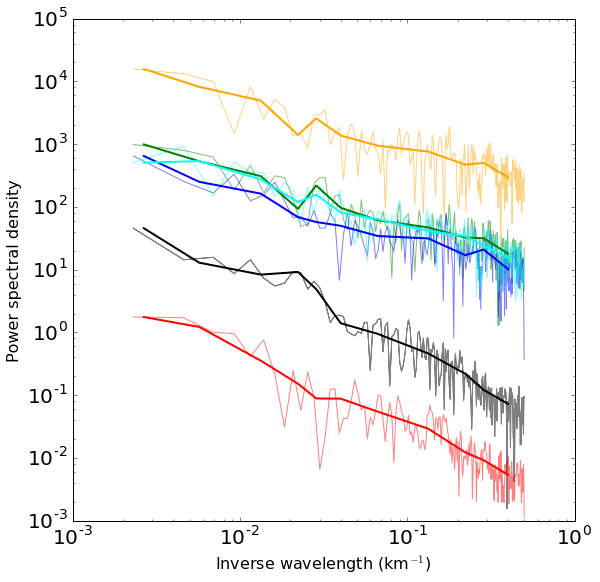

In [10]:
fig3 = plt.figure(3, figsize=(9,9), dpi = 600)

plt.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_25']), 'k', alpha=0.5)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_25']), 'r', alpha=0.5)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_25']), 'g', alpha=0.5)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_25']), 'b', alpha=0.5)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_25']), 'cyan', alpha=0.5)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_25']/100000), 'orange', alpha=0.5)

plt.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_25']), 'k', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['salinity_25']), 'r', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_25']), 'g', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['synecho_25']), 'b', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['pico_25']), 'cyan', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_25']/100000), 'orange', lw=2)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
plt.ylabel('Power spectral density', fontsize = 16)

plt.show()

# green = picoeuk*
# cyan = pro
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

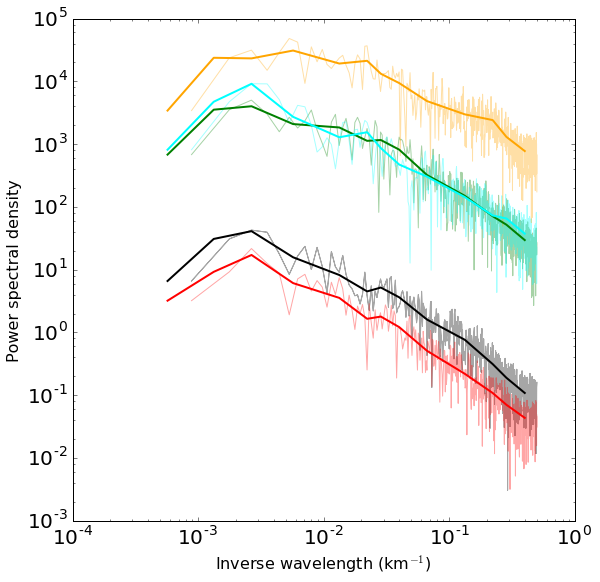

In [11]:
fig3 = plt.figure(3, figsize=(9,9), dpi = 600)

plt.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_34']), 'k', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_34']), 'r', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_34']), 'g', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_34']), 'b', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_34']), 'cyan', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_34']/100000), 'orange', alpha=0.35)

plt.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_34']), 'k', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['salinity_34']), 'r', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_34']), 'g', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['synecho_34']), 'b', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['pico_34']), 'cyan', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_34']/100000), 'orange', lw=2)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
plt.ylabel('Power spectral density', fontsize = 16)

plt.show()

# green = picoeuk
# cyan = pro*
# blue = synecho
# red = salinity
# black = temp
# orange = chl

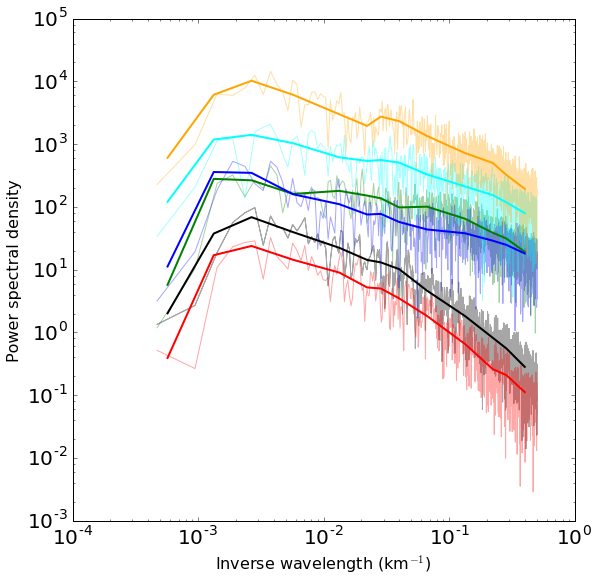

In [12]:
fig3 = plt.figure(3, figsize=(9,9), dpi = 600)

plt.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_35']), 'k', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_35']), 'r', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_35']), 'g', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_35']), 'b', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_35']), 'cyan', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_35']/100000), 'orange', alpha=0.35)

plt.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_35']), 'k', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['salinity_35']), 'r', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_35']), 'g', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['synecho_35']), 'b', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['pico_35']), 'cyan', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_35']/100000), 'orange', lw=2)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
plt.ylabel('Power spectral density', fontsize = 16)

plt.show()

# green = picoeuk
# cyan = pro
# blue = synecho
# red = salinity
# black = temp
# orange = chl

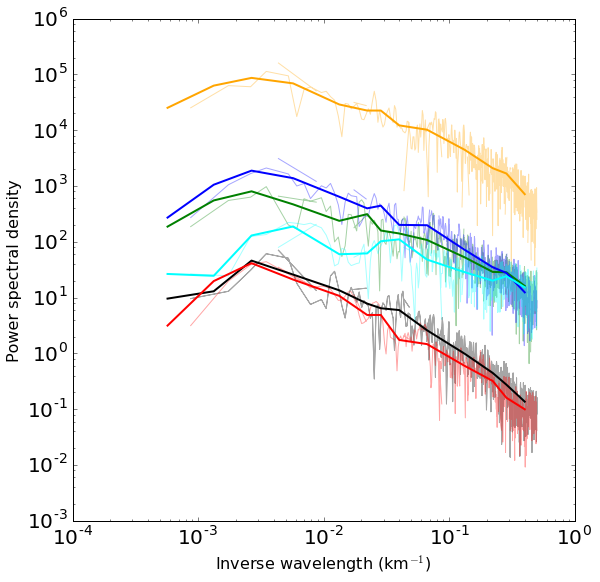

In [13]:
fig3 = plt.figure(3, figsize=(9,9), dpi = 600)

plt.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_43']), 'k', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_43']), 'r', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_43']), 'g', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_43']), 'b', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_43']), 'cyan', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_43']/100000), 'orange', alpha=0.35)

plt.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_43']), 'k', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['salinity_43']), 'r', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_43']), 'g', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['synecho_43']), 'b', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['pico_43']), 'cyan', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_43']/100000), 'orange', lw=2)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
plt.ylabel('Power spectral density', fontsize = 16)

plt.show()

# green = picoeuk*
# cyan = pro
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

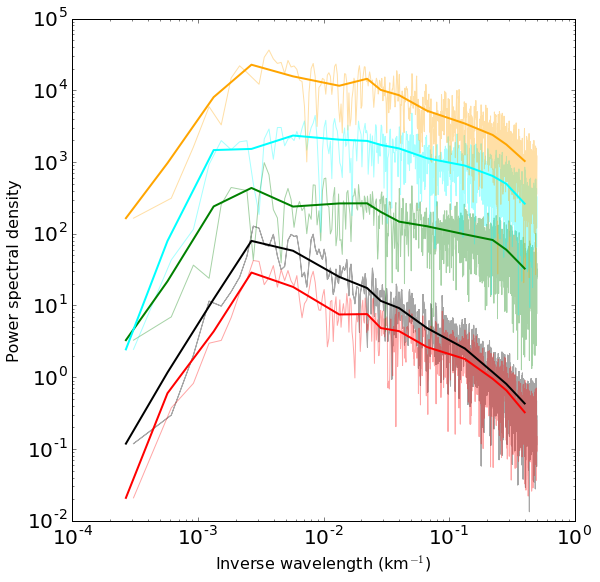

In [14]:
fig3 = plt.figure(3, figsize=(9,9), dpi = 600)

plt.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_46']), 'k', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_46']), 'r', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_46']), 'g', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_46']), 'b', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_46']), 'cyan', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_46']/100000), 'orange', alpha=0.35)

plt.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_46']), 'k', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['salinity_46']), 'r', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_46']), 'g', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['synecho_46']), 'b', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['pico_46']), 'cyan', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_46']/100000), 'orange', lw=2)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
plt.ylabel('Power spectral density', fontsize = 16)

plt.show()

# green = picoeuk
# cyan = pro
# blue = synecho
# red = salinity
# black = temp
# orange = chl

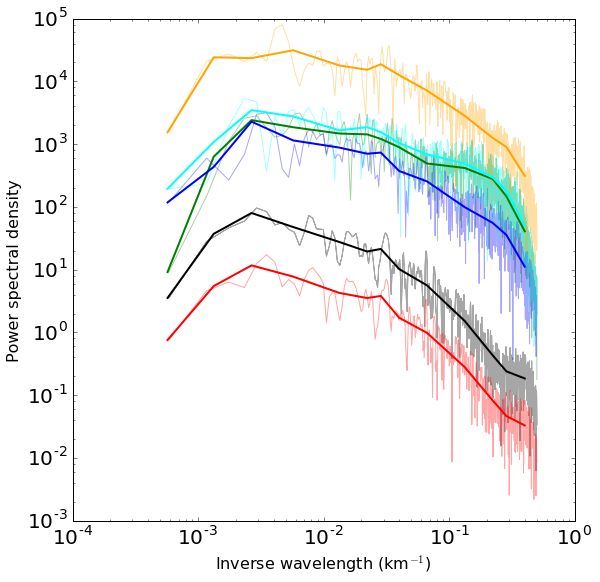

In [15]:
fig3 = plt.figure(3, figsize=(9,9), dpi = 600)

plt.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_87']), 'k', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_87']), 'r', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_87']), 'g', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_87']), 'b', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_87']), 'cyan', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_87']/100000), 'orange', alpha=0.35)

plt.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_87']), 'k', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['salinity_87']), 'r', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_87']), 'g', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['synecho_87']), 'b', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['pico_87']), 'cyan', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_87']/100000), 'orange', lw=2)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
plt.ylabel('Power spectral density', fontsize = 16)

plt.show()

# green = picoeuk
# cyan = pro*
# blue = synecho
# red = salinity
# black = temp
# orange = chl

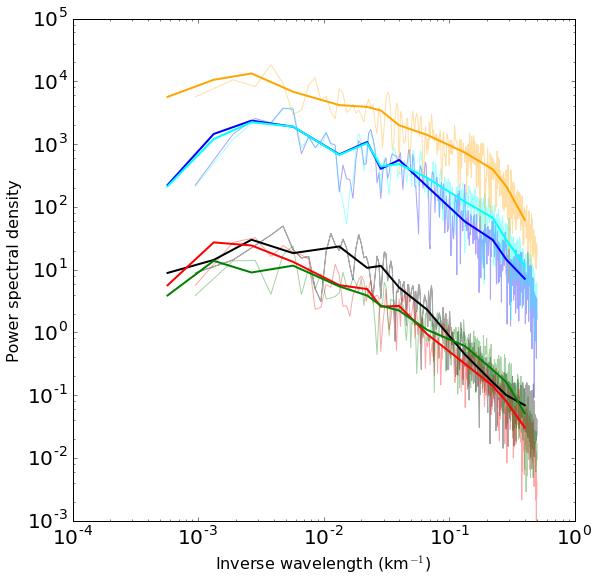

In [16]:
fig3 = plt.figure(3, figsize=(9,9), dpi = 600)

plt.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_65']), 'k', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_65']), 'r', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_65']/8), 'g', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_65']), 'b', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_65']), 'cyan', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_65']/1000000), 'orange', alpha=0.35)

plt.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_65']), 'k', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['salinity_65']), 'r', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_65']/8), 'g', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['synecho_65']), 'b', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['pico_65']), 'cyan', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_65']/1000000), 'orange', lw=2)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
plt.ylabel('Power spectral density', fontsize = 16)

plt.show()

# green = picoeuk
# cyan = pro*
# blue = synecho
# red = salinity
# black = temp
# orange = chl

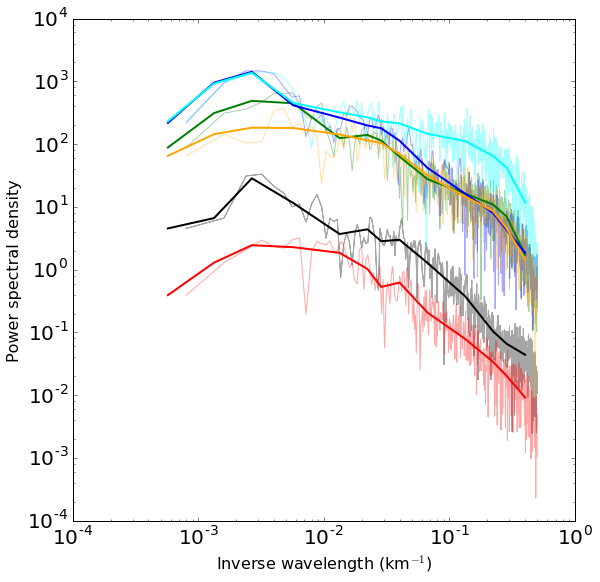

In [17]:
fig3 = plt.figure(3, figsize=(9,9), dpi = 600)

plt.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_69']), 'k', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_69']), 'r', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_69']), 'g', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_69']), 'b', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_69']), 'cyan', alpha=0.35)
plt.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_69']/10000000), 'orange', alpha=0.35)

plt.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_69']), 'k', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['salinity_69']), 'r', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_69']), 'g', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['synecho_69']), 'b', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['pico_69']), 'cyan', lw=2)
plt.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_69']/10000000), 'orange', lw=2)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
plt.ylabel('Power spectral density', fontsize = 16)

plt.show()

# green = picoeuk
# cyan = pro
# blue = synecho
# red = salinity
# black = temp
# orange = chl

## this track crosses the Kuroshio Extension

In [18]:
# average out the spectra for each track > 1000km
# need the length and other data form each track.